In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer,ToktokTokenizer
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.naive_bayes import MultinomialNB
from string import punctuation
from nltk.stem import WordNetLemmatizer
from autocorrect import spell
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [51]:
data = pd.read_csv("data_input/Womens Clothing E-Commerce Reviews.csv")

In [52]:
data = data[['Review Text','Recommended IND']]

In [53]:
data.shape

(23486, 2)

In [54]:
data.rename(columns={'Review Text':'review_text','Recommended IND':'recommended'},inplace=True)

In [55]:
data.head(2)

,review_text,recommended
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1


In [56]:
data.iloc[1,0]

'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.'

In [57]:
data.isna().sum()

review_text    845
recommended      0
dtype: int64

In [58]:
data['review_text'] = data['review_text'].fillna(' ')

In [59]:
data.isna().sum()

review_text    0
recommended    0
dtype: int64

In [60]:
data.dtypes

review_text    object
recommended     int64
dtype: object

EDA

In [61]:
data.loc[data["recommended"] == 0, "recommended"] = "Not Recommended"
data.loc[data["recommended"] == 1, "recommended"] = "Recommended"

In [62]:
data.dtypes

review_text    object
recommended    object
dtype: object

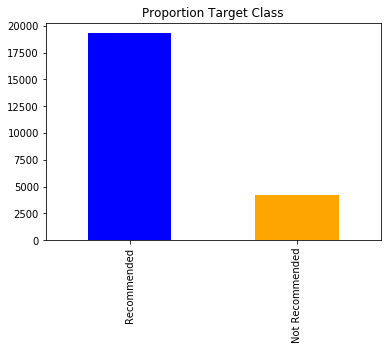

In [63]:
count_class=pd.value_counts(data["recommended"], sort= True)
count_class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Proportion Target Class')
plt.show()

In [64]:

count1 = Counter(" ".join(data[data['recommended']== 'Recommended']['review_text']).\
                 split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)


In [65]:
df1 = df1.rename(columns={0: "common_words", 1 : "count"})
df1.head(10)

,common_words,count
0,the,58954
1,i,40789
2,and,40389
3,a,35828
4,it,29788
5,is,25523
6,to,19767
7,this,16676
8,in,16506
9,but,12601


In [66]:
count2 = Counter(" ".join(data[data['recommended']== 'Not Recommended']['review_text']).\
                 split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)


In [67]:
df2 = df2.rename(columns={0: "common_words", 1 : "count"})
df2.head(10)

,common_words,count
0,the,15744
1,i,8841
2,and,8116
3,it,7514
4,a,6804
5,is,4799
6,to,4547
7,was,4137
8,this,4050
9,in,3705


Text Mining

In [68]:
tokenizer=ToktokTokenizer()
stopword_list=nltk.corpus.stopwords.words('english')

In [69]:
main_text = data['review_text']
target = data['recommended']

print(len(main_text))
print(len(target))

23486
23486


In [70]:
contractions_dict = {     
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I had",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "iit will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that had",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there had",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they had",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [71]:
def expand_contractions(text, contractions_dict):
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contractions_dict.get(match) \
            if contractions_dict.get(match) \
            else contractions_dict.get(match.lower())
        expanded_contraction = expanded_contraction
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text
def cons(text):
    text=expand_contractions(text,contractions_dict)
    return text

main_text = main_text.apply(cons)

In [ ]:
def autospell(text):
    spells = [spell(w) for w in (nltk.word_tokenize(text))]
    return " ".join(spells)

main_text = main_text.apply(autospell)

In [73]:
#Tolowercase
def to_lower(text):
    return ' '.join([w.lower() for w in word_tokenize(text)])
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

main_text = main_text.apply(to_lower)
main_text = main_text.apply(remove_special_characters)
main_text = main_text.apply(strip_punctuation)

In [74]:
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()
def lematizer(text):
    word_tokens = nltk.word_tokenize(text)
    lemmatized_word = [wordnet_lemmatizer.lemmatize(word) for word in word_tokens]
    return text
main_text = main_text.apply(lematizer)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\litaimut\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [75]:
from nltk.corpus import wordnet

def replaceElongated(word):
    repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
    repl = r'\1\2\3'
    if wordnet.synsets(word):
        return word
    repl_word = repeat_regexp.sub(repl, word)
    if repl_word != word:      
        return replaceElongated(repl_word)
    else:       
        return repl_word

def removeEmoticons(text):
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
    return text

main_text = main_text.apply(replaceElongated)
main_text = main_text.apply(removeEmoticons)

In [76]:
main_text

0        absolutely wonderful  silky and sexy and comfo...
1        love this dres  it is so prety  i hapened to f...
2        i had such high hopes for this dres and realy ...
3        i love  love  love this jumpsuit  it is fun  f...
4        this shirt is very flatering to al due to the ...
                               ...                        
23481    i was very hapy to snag this dres at such a gr...
23482    it reminds me of maternity clothes  soft  stre...
23483    this fit wel  but the top was very se through ...
23484    i bought this dres for a weding i have this su...
23485    this dres in a lovely platinum is feminine and...
Name: review_text, Length: 23486, dtype: object

In [77]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

main_text = main_text.apply(lambda x: tokenizer.tokenize(x))

In [78]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopword_list]
    return words

main_text = main_text.apply(lambda x : remove_stopwords(x))

In [79]:
main_text

0        [absolutely, wonderful, silky, sexy, comfortable]
1        [love, dres, prety, hapened, find, store, glad...
2        [high, hopes, dres, realy, wanted, work, initi...
3        [love, love, love, jumpsuit, fun, flirty, fabu...
4        [shirt, flatering, al, due, adjustable, front,...
                               ...                        
23481    [hapy, snag, dres, great, price, easy, slip, f...
23482    [reminds, maternity, clothes, soft, stretchy, ...
23483    [fit, wel, top, se, never, would, worked, glad...
23484    [bought, dres, weding, sumer, cute, unfortunat...
23485    [dres, lovely, platinum, feminine, fits, perfe...
Name: review_text, Length: 23486, dtype: object

In [81]:
from nltk.stem import SnowballStemmer

snowball_stemmer = SnowballStemmer('english')

def stem_update(text_list):
    text_list_new = []
    for word in text_list:
        word = snowball_stemmer.stem(word)
        text_list_new.append(word) 
    return text_list_new
main_text = main_text.apply(stem_update)


In [82]:
main_text

0                  [absolut, wonder, silki, sexi, comfort]
1        [love, dres, preti, hapen, find, store, glad, ...
2        [high, hope, dres, reali, want, work, initiali...
3        [love, love, love, jumpsuit, fun, flirti, fabu...
4        [shirt, flater, al, due, adjust, front, tie, p...
                               ...                        
23481    [hapi, snag, dres, great, price, easi, slip, f...
23482    [remind, matern, cloth, soft, stretchi, shini,...
23483    [fit, wel, top, se, never, would, work, glad, ...
23484    [bought, dres, wede, sumer, cute, unfortun, fi...
23485    [dres, love, platinum, feminin, fit, perfect, ...
Name: review_text, Length: 23486, dtype: object

In [83]:
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)
main_text = main_text.apply(drop_numbers)

In [84]:
main_text

0                        absolut wonder silki sexi comfort
1        love dres preti hapen find store glad bc never...
2        high hope dres reali want work initiali order ...
3        love love love jumpsuit fun flirti fabul everi...
4        shirt flater al due adjust front tie perfect l...
                               ...                        
23481    hapi snag dres great price easi slip flater cu...
23482    remind matern cloth soft stretchi shini materi...
23483    fit wel top se never would work glad abl tri s...
23484    bought dres wede sumer cute unfortun fit perfe...
23485    dres love platinum feminin fit perfect easi we...
Name: review_text, Length: 23486, dtype: object

In [85]:
df = pd.concat([main_text,target],axis=1)

In [86]:
df.head(2)

,review_text,recommended
0,absolut wonder silki sexi comfort,Recommended
1,love dres preti hapen find store glad bc never...,Recommended


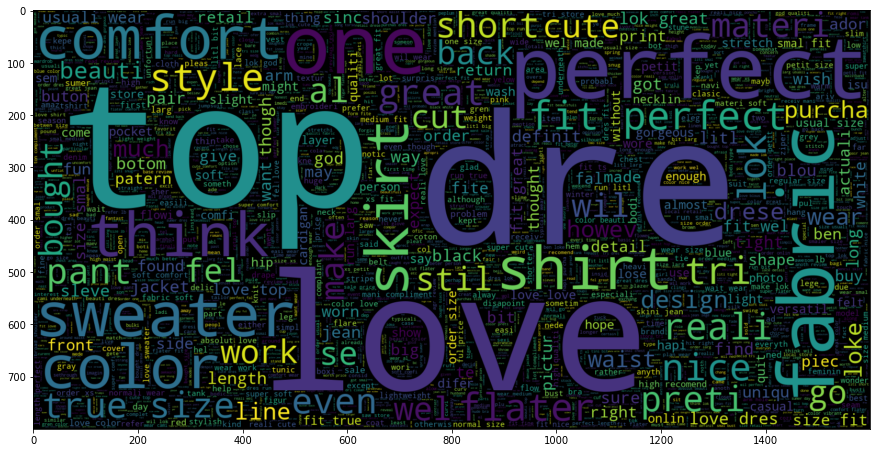

In [87]:


plt.figure(figsize = (15,15)) # Text that is recommended
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.recommended == 'Recommended'].review_text))
plt.imshow(wc , interpolation = 'bilinear')

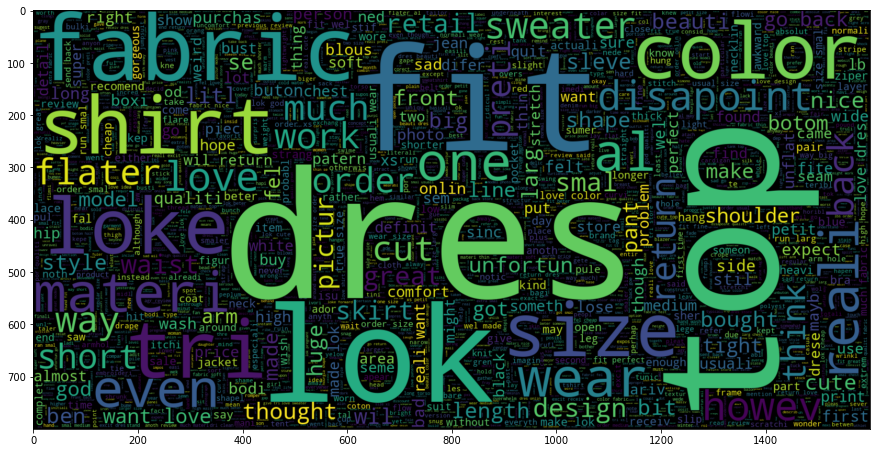

In [88]:
plt.figure(figsize = (15,15)) # Text that is not recommended
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.recommended == 'Not Recommended'].review_text))
plt.imshow(wc , interpolation = 'bilinear')

Modelling

In [89]:
cv=CountVectorizer()


train_data,test_data = train_test_split(df,train_size=0.8,random_state=0)

X_train = cv.fit_transform(train_data['review_text'])
y_train = train_data['recommended']
X_test = cv.transform(test_data['review_text'])
y_test = test_data['recommended']

In [90]:
nb = MultinomialNB()
nb.fit(X_train,y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [91]:
nb_predict=nb.predict(X_test)

In [92]:
nb_report = accuracy_score(y_test,nb_predict)
print('Accuracy:',nb_report)

Accuracy: 0.8914431673052363


In [93]:
nb_report_ = classification_report(y_test,nb_predict)
print(nb_report_)

                 precision    recall  f1-score   support

Not Recommended       0.72      0.63      0.67       828
    Recommended       0.92      0.95      0.94      3870

       accuracy                           0.89      4698
      macro avg       0.82      0.79      0.80      4698
   weighted avg       0.89      0.89      0.89      4698



In [94]:
nb_cm=confusion_matrix(y_test.values, nb.predict(X_test))

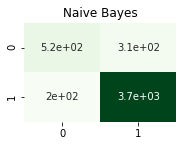

In [95]:
plt.subplot(2,2,2)
plt.title("Naive Bayes")
sns.heatmap(nb_cm, annot = True, cmap="Greens",cbar=False);

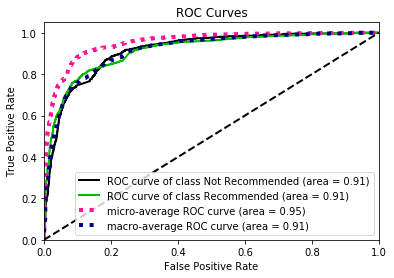

In [96]:
skplt.metrics.plot_roc(y_test, nb.predict_proba(X_test)) 